In [1]:
import pandas as pd  
import numpy as np   

results = pd.read_csv("results.csv")
shootouts = pd.read_csv("shootouts.csv")
goalscorers = pd.read_csv("goalscorers.csv")
former_names = pd.read_csv("former_names.csv")


In [2]:
# Combining results and shootouts to know who actually won each match

# Making a copy of results to work with
matches = results.copy()

matches["date"] = pd.to_datetime(matches["date"])
shootouts["date"] = pd.to_datetime(shootouts["date"])

#Keeping only useful columns from shootouts
shootouts_small = shootouts[["date", "home_team", "away_team", "winner"]]

# adding shootout winner info onto the matches table
matches = matches.merge(
    shootouts_small,
    how="left",
    on=["date", "home_team", "away_team"],
    suffixes=("", "_shootout")
)

# Now deciding who actually won each match
def decide_winner(row):
    # Normal win in regular time
    if row["home_score"] > row["away_score"]:
        return "home"
    elif row["home_score"] < row["away_score"]:
        return "away"
    else:
        # Scores are equal (draw in regular time)
        if pd.isna(row["winner"]):
            return "draw"
        else:
            # There was a shootout so winner column tells us who won
            if row["winner"] == row["home_team"]:
                return "home"
            else:
                return "away"

matches["winner_label"] = matches.apply(decide_winner, axis=1)

# For the baseline model, we will predict: 1 = home team wins, 0 = home team does NOT win (away win or draw)
matches["home_win"] = (matches["winner_label"] == "home").astype(int)

print(matches[["date", "home_team", "away_team", "home_score", "away_score", "winner_label", "home_win"]].head())

print("\nCount of each result type:")
print(matches["winner_label"].value_counts())

        date home_team away_team  home_score  away_score winner_label  \
0 1872-11-30  Scotland   England           0           0         draw   
1 1873-03-08   England  Scotland           4           2         home   
2 1874-03-07  Scotland   England           2           1         home   
3 1875-03-06   England  Scotland           2           2         draw   
4 1876-03-04  Scotland   England           3           0         home   

   home_win  
0         0  
1         1  
2         1  
3         0  
4         1  

Count of each result type:
winner_label
home    24197
away    14030
draw    10446
Name: count, dtype: int64


In [3]:
# Select features and create train/test split
from sklearn.model_selection import train_test_split

# Make a simple numeric 'year' column from the date
matches["year"] = matches["date"].dt.year

# Features we will use for the baseline model
feature_cols = ["home_team", "away_team", "tournament", "neutral", "year"]

# X = input features, y = target (home team wins or not)
X = matches[feature_cols].copy()
y = matches["home_win"].copy()

# Split into training set and test set,20% of the data is kept aside for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# Quick look at the training features
X_train.head()

Training size: 38938
Test size: 9735


,home_team,away_team,tournament,neutral,year
25139,Serbia,Japan,Millennium Cup,True,2001
8292,Indonesia,Japan,Asian Games,True,1970
7871,Austria,Scotland,FIFA World Cup qualification,False,1969
33837,Sudan,Palestine,Friendly,False,2010
553,China PR,Philippines,Far Eastern Championship Games,False,1919


In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Tell sklearn which columns are categorical and which are numeric
categorical_cols = ["home_team", "away_team", "tournament"]
numeric_cols = ["neutral", "year"]

# Preprocessor: Pass numeric columns as they are
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

# Define the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,       # number of trees 
    random_state=42,
    n_jobs=-1             
)

#Create a pipeline that: First applies preprocessing,Then trains the Random Forest
rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", rf_model),
    ]
)

# train the model on the training data
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['home_team', 'away_team',
                                                   'tournament']),
                                                 ('num', 'passthrough',
                                                  ['neutral', 'year'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [5]:
# Tune Random Forest hyperparameters using GridSearchCV

from sklearn.model_selection import GridSearchCV

# We are tuning the "model" step inside rf_pipeline.
param_grid = {
    "model__n_estimators": [100, 200, 400],      # number of trees
    "model__max_depth": [None, 10, 20],          # how deep each tree can grow
    "model__min_samples_split": [2, 5, 10],      # min rows needed to split a node
    "model__min_samples_leaf": [1, 2, 4],        # min rows in each leaf
}

# GridSearchCV will:train the model many times with different combinations of these settings
# use cross-validation on the training set,pick the best combination based on accuracy
grid_search = GridSearchCV(
    estimator=rf_pipeline, 
    param_grid=param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring="accuracy",      # metric to compare settings
    n_jobs=1,               # use all CPU cores
    verbose=2                # print progress
)

#training many models.
grid_search.fit(X_train, y_train)

print("Best accuracy from CV:", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

#best model  with best settings
best_rf_pipeline = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   2.9s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   3.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   3.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=400; total time=   6.0s
[CV] END model__max_d

In [6]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set using the tuned model
y_pred = best_rf_pipeline.predict(X_test)

# Measure accuracy
test_acc = accuracy_score(y_test, y_pred)
print("Test accuracy of tuned Random Forest:", test_acc)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

Test accuracy of tuned Random Forest: 0.6746789933230611

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      4895
           1       0.68      0.65      0.67      4840

    accuracy                           0.67      9735
   macro avg       0.67      0.67      0.67      9735
weighted avg       0.67      0.67      0.67      9735



In [9]:
#Keep only matches where someone actually wins

# Filter out rows where the result is 'draw'
matches_no_draw = matches[matches["winner_label"] != "draw"].copy()

# New target: 1 if home wins, 0 if away wins
matches_no_draw["home_win"] = (matches_no_draw["winner_label"] == "home").astype(int)

print("Total matches with a clear winner (no draws):", matches_no_draw.shape[0])
print("\nCounts of home_win (1 = home wins, 0 = away wins):")
print(matches_no_draw["home_win"].value_counts())

# Quick peek at the data
matches_no_draw[["date", "home_team", "away_team", "winner_label", "home_win"]].head()

Total matches with a clear winner (no draws): 38227

Counts of home_win (1 = home wins, 0 = away wins):
home_win
1    24197
0    14030
Name: count, dtype: int64


,date,home_team,away_team,winner_label,home_win
1,1873-03-08,England,Scotland,home,1
2,1874-03-07,Scotland,England,home,1
4,1876-03-04,Scotland,England,home,1
5,1876-03-25,Scotland,Wales,home,1
6,1877-03-03,England,Scotland,away,0


In [10]:
from sklearn.model_selection import train_test_split

feature_cols = ["home_team", "away_team", "tournament", "neutral", "year"]

X = matches_no_draw[feature_cols].copy()
y = matches_no_draw["home_win"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y            # keep class balance
)

print("Training size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# Quick peek
X_train.head()

Training size: 30581
Test size: 7646


,home_team,away_team,tournament,neutral,year
16018,Kuwait,United Arab Emirates,Gulf Cup,True,1988
29252,Romania,Armenia,FIFA World Cup qualification,False,2005
47335,Serbia,England,UEFA Euro,True,2024
18838,French Guiana,Guadeloupe,CFU Caribbean Cup qualification,False,1993
31820,Curaçao,Suriname,Friendly,False,2008


In [11]:
team_rows = []

# Go through every match and create a row for home team and away team
for _, row in matches_no_draw.iterrows():
    # Home team row
    team_rows.append({
        "team": row["home_team"],
        "goals_for": row["home_score"],
        "goals_against": row["away_score"],
        "win": 1 if row["winner_label"] == "home" else 0
    })
    
    # Away team row
    team_rows.append({
        "team": row["away_team"],
        "goals_for": row["away_score"],
        "goals_against": row["home_score"],
        "win": 1 if row["winner_label"] == "away" else 0
    })

team_df = pd.DataFrame(team_rows)

# Group by team to compute stats
team_stats = team_df.groupby("team").agg(
    matches_played=("win", "count"),
    wins=("win", "sum"),
    avg_goals_for=("goals_for", "mean"),
    avg_goals_against=("goals_against", "mean")
)

# Extra useful stats
team_stats["win_rate"] = team_stats["wins"] / team_stats["matches_played"]
team_stats["avg_goal_diff"] = (
    team_stats["avg_goals_for"] - team_stats["avg_goals_against"]
)

team_stats.head()

,matches_played,wins,avg_goals_for,avg_goals_against,win_rate,avg_goal_diff
team,,,,,,
Abkhazia,25,16,1.760000,0.760000,0.640000,1.000000
Afghanistan,110,35,1.009091,2.354545,0.318182,-1.345455
Albania,308,109,1.042208,1.714286,0.353896,-0.672078
Alderney,134,5,0.529851,4.611940,0.037313,-4.082090
Algeria,454,282,1.744493,1.068282,0.621145,0.676211


In [12]:
# Copy matches_no_draw 
matches_feat = matches_no_draw.copy()

#preparing two copies of team_stats with prefixes
home_stats = team_stats.add_prefix("home_")   # home_matches_played, home_win_rate, etc.
away_stats = team_stats.add_prefix("away_")   # away_matches_played, away_win_rate, etc.

# Merge home team stats
matches_feat = matches_feat.merge(
    home_stats,
    how="left",
    left_on="home_team",
    right_index=True
)

# Merge away team stats
matches_feat = matches_feat.merge(
    away_stats,
    how="left",
    left_on="away_team",
    right_index=True
)

# For some very new/rare teams, stats might be missing (NaN).
for col in ["home_win_rate", "home_avg_goal_diff",
            "away_win_rate", "away_avg_goal_diff"]:
    matches_feat[col] = matches_feat[col].fillna(0.0)

matches_feat[[
    "home_team", "away_team",
    "home_win_rate", "away_win_rate",
    "home_avg_goal_diff", "away_avg_goal_diff"
]].head()

,home_team,away_team,home_win_rate,away_win_rate,home_avg_goal_diff,away_avg_goal_diff
1,England,Scotland,0.744934,0.603008,1.588796,0.598496
2,Scotland,England,0.603008,0.744934,0.598496,1.588796
4,Scotland,England,0.603008,0.744934,0.598496,1.588796
5,Scotland,Wales,0.603008,0.415027,0.598496,-0.457961
6,England,Scotland,0.744934,0.603008,1.588796,0.598496


In [13]:
from sklearn.model_selection import train_test_split

# Features now include team strength numbers as well
feature_cols = [
    "home_team", "away_team", "tournament",  # categorical
    "neutral", "year",                       # simple numeric
    "home_win_rate", "away_win_rate",       # strength features
    "home_avg_goal_diff", "away_avg_goal_diff"
]

X = matches_feat[feature_cols].copy()
y = matches_feat["home_win"].copy()   # 1 = home wins, 0 = away wins

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

X_train.head()

Training size: 30581
Test size: 7646


,home_team,away_team,tournament,neutral,year,home_win_rate,away_win_rate,home_avg_goal_diff,away_avg_goal_diff
16018,Kuwait,United Arab Emirates,Gulf Cup,True,1988,0.561644,0.534335,0.583170,0.236052
29252,Romania,Armenia,FIFA World Cup qualification,False,2005,0.585237,0.305164,0.453427,-1.009390
47335,Serbia,England,UEFA Euro,True,2024,0.606299,0.744934,0.637795,1.588796
18838,French Guiana,Guadeloupe,CFU Caribbean Cup qualification,False,1993,0.375000,0.513158,-0.270833,0.320175
31820,Curaçao,Suriname,Friendly,False,2008,0.492806,0.561056,0.050360,0.600660


In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Categorical and numeric columns
categorical_cols = ["home_team", "away_team", "tournament"]
numeric_cols = [
    "neutral", "year",
    "home_win_rate", "away_win_rate",
    "home_avg_goal_diff", "away_avg_goal_diff"
]

# One-hot encoder for categorical columns
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,   #more trees than before
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

#preprocessing + model
rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", rf_model),
    ]
)

# Train the model
rf_pipeline.fit(X_train, y_train)

# Evaluatio on test set
y_pred = rf_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("Test accuracy with strength features:", test_acc)


print(classification_report(y_test, y_pred))

Test accuracy with strength features: 0.724954224431075
              precision    recall  f1-score   support

           0       0.64      0.59      0.61      2806
           1       0.77      0.81      0.79      4840

    accuracy                           0.72      7646
   macro avg       0.70      0.70      0.70      7646
weighted avg       0.72      0.72      0.72      7646



In [15]:
import matplotlib.pyplot as plt

def predict_match_interactive():
    print("=== Match prediction tool ===")
    
    # 1. Get user inputs
    home_team = input("Enter HOME team name (exactly as in dataset: ")
    away_team = input("Enter AWAY team name: ")
    tournament = input("Enter tournament name (e.g. 'Friendly', 'FIFA World Cup'): ")
    
    venue_type = input("Is this a NEUTRAL venue? (yes/no): ").strip().lower()
    neutral = venue_type in ["yes", "y", "true", "1"]
    
    year_text = input("Enter match year (e.g. 2024): ").strip()
    try:
        year = int(year_text)
    except ValueError:
        year = 2024  # default if user types something weird
    
    home_row = team_stats.loc[home_team] if home_team in team_stats.index else None
    away_row = team_stats.loc[away_team] if away_team in team_stats.index else None
    
    def get_stat(row, col):
        if row is None:
            return 0.0
        return row[col]
    
    home_win_rate = get_stat(home_row, "win_rate")
    away_win_rate = get_stat(away_row, "win_rate")
    home_gd = get_stat(home_row, "avg_goal_diff")
    away_gd = get_stat(away_row, "avg_goal_diff")
    
    data = {
        "home_team": [home_team],
        "away_team": [away_team],
        "tournament": [tournament],
        "neutral": [neutral],
        "year": [year],
        "home_win_rate": [home_win_rate],
        "away_win_rate": [away_win_rate],
        "home_avg_goal_diff": [home_gd],
        "away_avg_goal_diff": [away_gd],
    }
    X_new = pd.DataFrame(data)
    
    #Predict probabilities with the trained Random Forest pipeline
    proba = rf_pipeline.predict_proba(X_new)[0]
    # classes_ should be [0, 1] → 0 = away wins, 1 = home wins
    prob_away = float(proba[0])
    prob_home = float(proba[1])
    
    #summary
    print("\n=== Prediction summary ===")
    print(f"Home team: {home_team}")
    print(f"Away team: {away_team}")
    print(f"Tournament: {tournament}")
    print(f"Neutral venue: {neutral}")
    print(f"Year: {year}")
    print()
    print(f"Estimated probability {home_team} WINS: {prob_home:.2%}")
    print(f"Estimated probability {away_team} WINS: {prob_away:.2%}")
    
    # historic stats if available
    print("\n=== Historic team stats (from training data) ===")
    if home_row is not None:
        print(f"{home_team}: win rate {home_win_rate:.1%}, avg goal diff {home_gd:.2f}")
    else:
        print(f"{home_team}: no stats found in dataset (using neutral defaults).")
    
    if away_row is not None:
        print(f"{away_team}: win rate {away_win_rate:.1%}, avg goal diff {away_gd:.2f}")
    else:
        print(f"{away_team}: no stats found in dataset (using neutral defaults).")
    
    #bar chart of probabilities
    plt.figure()
    plt.bar([home_team, away_team], [prob_home, prob_away])
    plt.ylabel("Win probability")
    plt.title("Model prediction")
    plt.ylim(0, 1)
    plt.show()



=== Match prediction tool ===


Enter HOME team name (exactly as in dataset, e.g. 'Brazil'):  Brazil
Enter AWAY team name:  Argentina
Enter tournament name (e.g. 'Friendly', 'FIFA World Cup'):  FIFA World Cup
Is this a NEUTRAL venue? (yes/no):  no
Enter match year (e.g. 2024):  2024



=== Prediction summary ===
Home team: Brazil
Away team: Argentina
Tournament: FIFA World Cup
Neutral venue: False
Year: 2024

Estimated probability Brazil WINS: 49.87%
Estimated probability Argentina WINS: 50.13%

=== Historic team stats (from training data) ===
Brazil: win rate 79.2%, avg goal diff 1.57
Argentina: win rate 72.7%, avg goal diff 1.13


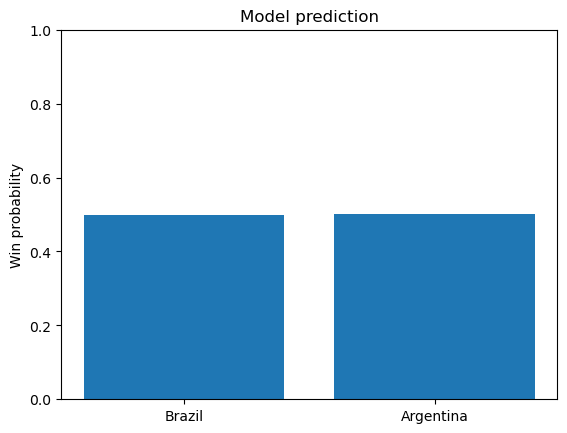

In [16]:
predict_match_interactive()